In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import optuna
import shap
import matplotlib.pyplot as plt


In [2]:
# Load datasets
train_df = pd.read_csv("/kaggle/input/parkinson/train.csv")
test_df = pd.read_csv("/kaggle/input/parkinson/test.csv")
val_df = pd.read_csv("/kaggle/input/parkinson/val.csv")

# Define features and target
target_col = "motor_UPDRS"
target_and_related = ["motor_UPDRS", "subject#", "total_UPDRS"]

# Split datasets into features (X) and target (y)
X_train = train_df.drop(columns=target_and_related)
y_train = train_df[target_col]

X_test = test_df.drop(columns=target_and_related)
y_test = test_df[target_col]

X_val = val_df.drop(columns=target_and_related)
y_val = val_df[target_col]


In [3]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform on training data, transform on test and validation data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Convert back to DataFrame to retain column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)

# Save the scaler
joblib.dump(scaler, "/kaggle/working/scaler.pkl")

print("Data scaling completed and scaler saved.")


Data scaling completed and scaler saved.


In [4]:
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Create bins for stratification
y_bins = pd.qcut(y_train, q=num_folds, labels=False)

cv_scores = []
for train_idx, val_idx in skf.split(X_train_scaled, y_bins):
    X_fold_train, X_fold_val = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = LinearRegression()
    model.fit(X_fold_train, y_fold_train)
    
    y_pred = model.predict(X_fold_val)
    mse = mean_squared_error(y_fold_val, y_pred)
    
    cv_scores.append(mse)

print(f"Cross-Validation MSE Scores: {cv_scores}")
print(f"Mean MSE: {np.mean(cv_scores)}")


Cross-Validation MSE Scores: [60.74519669458, 55.5324096589612, 56.32256987615856, 55.50394877247646, 54.99435289514004]
Mean MSE: 56.619695579463254


In [5]:
def objective(trial):
    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
    
    model = LinearRegression(fit_intercept=fit_intercept)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred)
    
    return mse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Best Parameters:", study.best_params)


[I 2025-02-22 14:18:14,952] A new study created in memory with name: no-name-9a8771d4-b96b-4064-b69c-efc78386f709
[I 2025-02-22 14:18:14,966] Trial 0 finished with value: 508.9540400310313 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 508.9540400310313.
[I 2025-02-22 14:18:14,976] Trial 1 finished with value: 508.9540400310313 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 508.9540400310313.
[I 2025-02-22 14:18:14,986] Trial 2 finished with value: 508.9540400310313 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 508.9540400310313.
[I 2025-02-22 14:18:14,995] Trial 3 finished with value: 56.8667193180046 and parameters: {'fit_intercept': True}. Best is trial 3 with value: 56.8667193180046.
[I 2025-02-22 14:18:15,006] Trial 4 finished with value: 508.9540400310313 and parameters: {'fit_intercept': False}. Best is trial 3 with value: 56.8667193180046.
[I 2025-02-22 14:18:15,018] Trial 5 finished with value: 56.8667193180

Best Parameters: {'fit_intercept': True}


In [6]:
# Train the final model with the best hyperparameters
best_params = study.best_params
final_model = LinearRegression(**best_params)
final_model.fit(X_train_scaled, y_train)

import joblib

# Save the trained model
joblib.dump(final_model, "/kaggle/working/linear_regression_model.pkl")

# Save the scaler
joblib.dump(scaler, "/kaggle/working/scaler.pkl")

print("Model and scaler saved successfully!")


Model and scaler saved successfully!


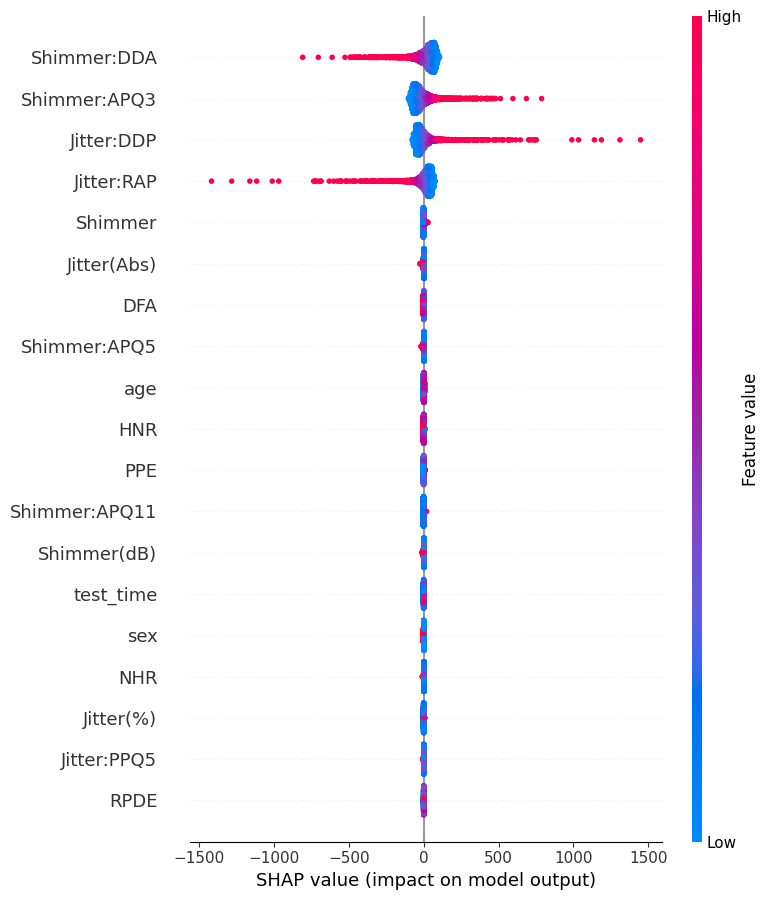

In [7]:
explainer = shap.Explainer(final_model, X_train_scaled)
shap_values = explainer(X_train_scaled)

# Summary Plot
shap.summary_plot(shap_values, X_train)


In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on the test set
y_test_pred = final_model.predict(X_test_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)  # RMSE calculation
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Print the results
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")
print(f"Test R² Score: {r2}")


Test MSE: 55.25752376952746
Test RMSE: 7.4335404599374755
Test MAE: 6.257814703578837
Test R² Score: 0.1669388767683817
